In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
%matplotlib inline 
pd.options.display.max_columns = None
mpl.rcParams['figure.dpi']= 150

X_train = pd.read_csv("../train_values.csv")
y_train = pd.read_csv("../train_labels.csv")
train = pd.concat([X_train, y_train], axis=1)

# Executive Summary
In this report I am going to present my analysis of the HMDA mortgage application dataset, as well as the machine learning model I created for the aforementioned data. The dataset includes information about 500000 mortage applications. After doing basic exploratory analysis, visualization, as well as some data cleaning and processing, I managed to identify the most essential features of the dataset, i.e. those that provided the largest amount of information about the separation of the two label classes (mortgage accepted/rejected). Those features were subsequentely used for the creation of a binary classifier capable of predicting whether an application will be accepted or not, with an accuracy of 72%. The most important features of the dataset are the following:

* *lender* - A categorical with no ordering indicating which of the lenders was the authority in approving or denying this loan
* *loan_amount* - Size of the requested loan in thousands of dollars
* *msa_md* - A categorical with no ordering indicating Metropolitan Statistical Area/Metropolitan Division 
* *state_code* - A categorical with no ordering indicating the U.S. state
* *applicant_income* - In thousands of dollars
* *number_of_owner-occupied_units* - Number of dwellings, including individual condominiums, that are lived in by the owner
* *minority_population* - Number of people that belong in a minority group, a new feature that was created for the purposes of this analysis
* *tract_family_income* - The tract median family income in dollars, another feature that was created for the purposes of this analysis

# Exploratory Data Analysis
First of all, we are going to examine the total number of non-null values for each feature.

In [2]:
train.count()

row_id                            500000
loan_type                         500000
property_type                     500000
loan_purpose                      500000
occupancy                         500000
loan_amount                       500000
preapproval                       500000
msa_md                            500000
state_code                        500000
county_code                       500000
applicant_ethnicity               500000
applicant_race                    500000
applicant_sex                     500000
applicant_income                  460052
population                        477535
minority_population_pct           477534
ffiecmedian_family_income         477560
tract_to_msa_md_income_pct        477486
number_of_owner-occupied_units    477435
number_of_1_to_4_family_units     477470
lender                            500000
co_applicant                      500000
row_id                            500000
accepted                          500000
dtype: int64

As we can see, some of the features have a fair number of missing values. Furthermore, we can read on the dataset description that some categorical features include categories that correspond to missing values, e.g. the -1 category of *msa_md* column indicates a missing value. We are going to remove those, so we have a clearer view of our dataset.

In [3]:
train.drop("row_id", axis=1, inplace=True)

replace_dict = {
    'msa_md': -1,
    'state_code': -1,
    'county_code': -1,
    'occupancy': 3,
    'preapproval': 3,
    'applicant_ethnicity': [3, 4, 5],
    "applicant_race": [6, 7, 8],
    "applicant_sex": [3, 4, 5]
}

cat_cols_few = ["loan_type", "property_type", "loan_purpose", "occupancy", "preapproval",
                "applicant_ethnicity", "applicant_race", "applicant_sex", "co_applicant"] 

cat_cols_many = ["msa_md", "state_code", "county_code", "lender"]

numerical_cols = ["loan_amount", "applicant_income", "population", "minority_population_pct",
                 "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
                 "number_of_owner-occupied_units", "number_of_1_to_4_family_units"]

train.replace(replace_dict, np.nan, inplace = True)
train.count()

loan_type                         500000
property_type                     500000
loan_purpose                      500000
occupancy                         497811
loan_amount                       500000
preapproval                        88891
msa_md                            423018
state_code                        480868
county_code                       479534
applicant_ethnicity               436883
applicant_race                    434460
applicant_sex                     458682
applicant_income                  460052
population                        477535
minority_population_pct           477534
ffiecmedian_family_income         477560
tract_to_msa_md_income_pct        477486
number_of_owner-occupied_units    477435
number_of_1_to_4_family_units     477470
lender                            500000
co_applicant                      500000
accepted                          500000
dtype: int64

After removing the aforementioned categories, we see that certain features have significantly fewer values. This has to be dealt with before we create the binary classifier, as machine learning models can't accept null values on a dataset.

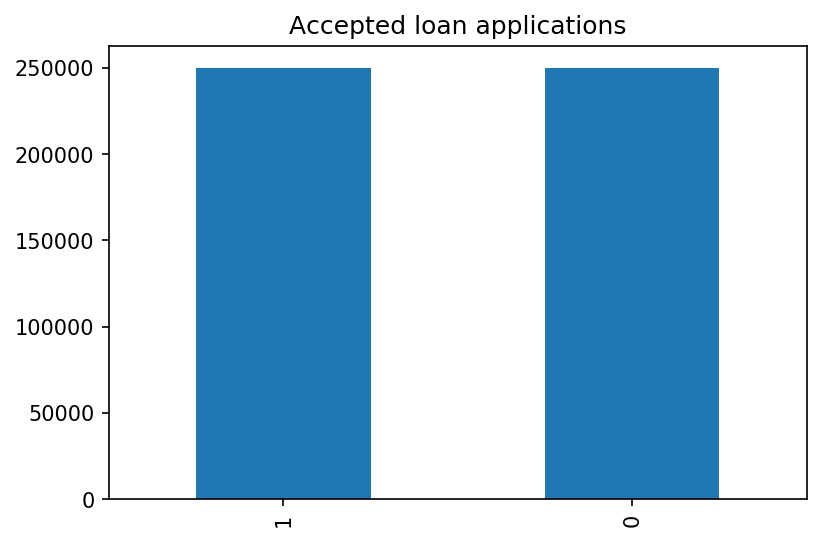

1    0.500228
0    0.499772
Name: accepted, dtype: float64

In [4]:
train["accepted"].value_counts().plot(kind='bar')
plt.title('Accepted loan applications')
plt.show()
train["accepted"].value_counts(normalize = 'index')


The classes of our dataset are almost perfectly balanced. This is helpful, as it simplifies the creation of the machine learning model.

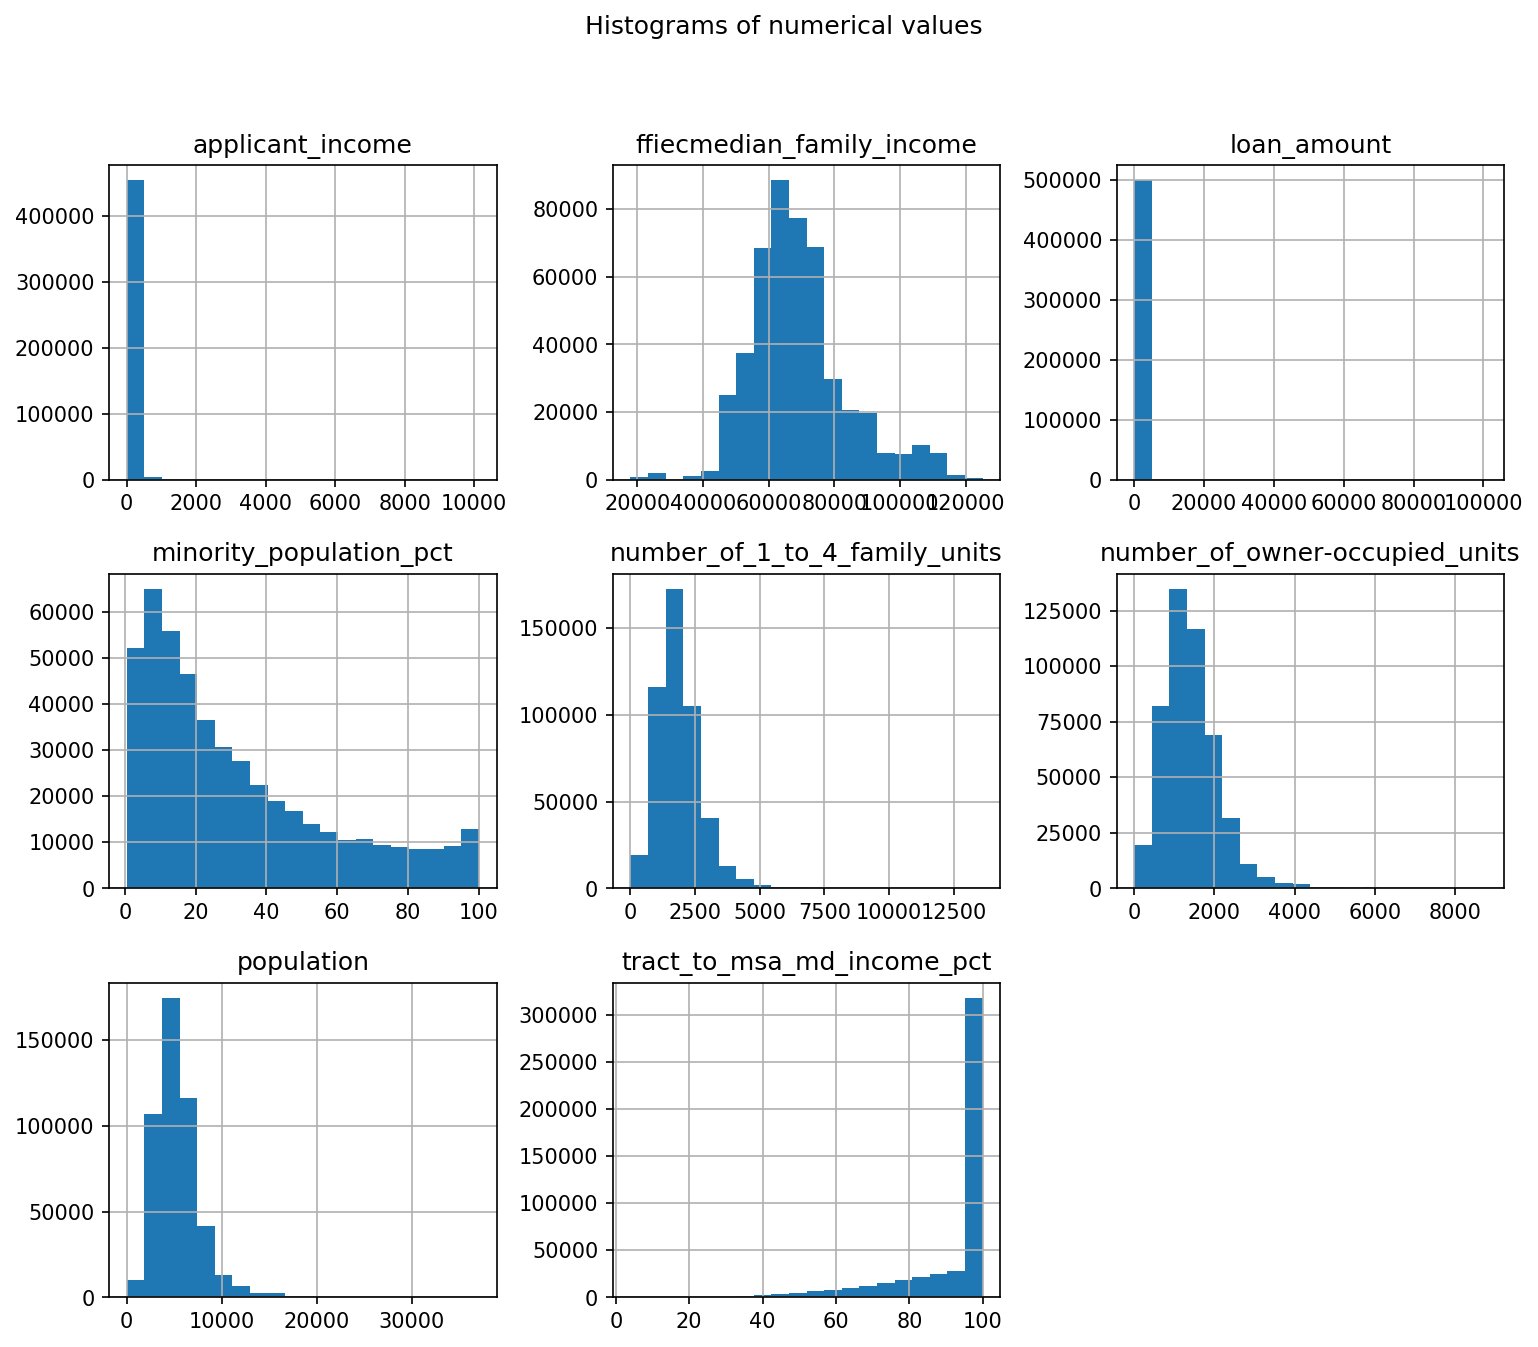

Skewness of numerical columns:


loan_amount                       76.552786
applicant_income                  22.277181
population                         2.864237
minority_population_pct            1.009139
ffiecmedian_family_income          0.773280
tract_to_msa_md_income_pct        -1.963872
number_of_owner-occupied_units     1.881743
number_of_1_to_4_family_units      2.016264
dtype: float64

In [5]:
train[numerical_cols].hist(figsize=(12,10), bins=20)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns:")
train[numerical_cols].skew()

As we can see on the histograms, as well as the list of skewness values, a few of the numerical features, especially *loan_amount* and *applicant_income* are highly skewed. We are going to fix that by applying the logarithmic function on them, as it is helpful to have features with low skewness and a distribution that is close to normal. This will enable us to create more meaningful visualizations, as well as a better machine learning model.

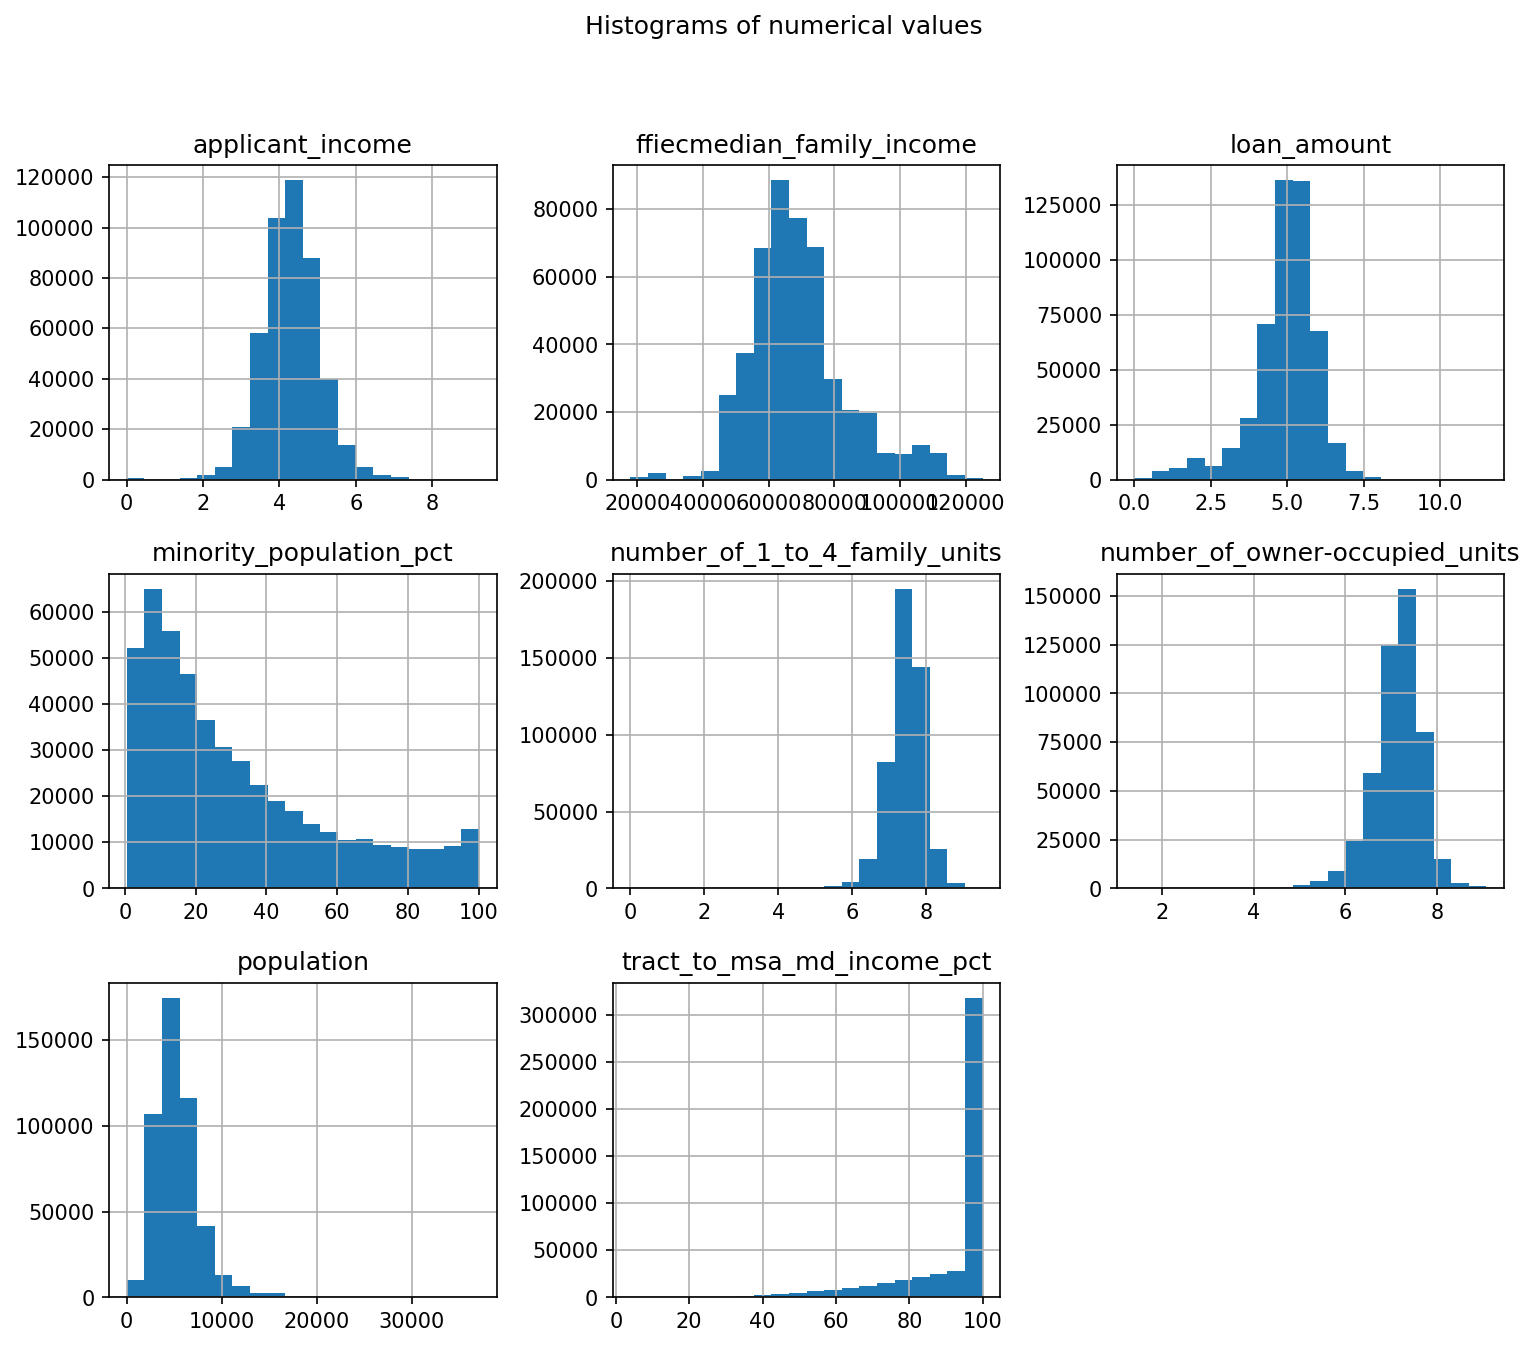

Skewness of numerical columns after applying log function:


loan_amount                      -1.190548
applicant_income                  0.026275
population                        2.864237
minority_population_pct           1.009139
ffiecmedian_family_income         0.773280
tract_to_msa_md_income_pct       -1.963872
number_of_owner-occupied_units   -1.076900
number_of_1_to_4_family_units    -1.568488
dtype: float64

In [6]:
import math
to_log = ["loan_amount", "applicant_income", "number_of_owner-occupied_units", "number_of_1_to_4_family_units"]
train[to_log] = train[to_log].applymap(math.log)

train[numerical_cols].hist(figsize=(12,10), bins=20)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns after applying log function:")
train[numerical_cols].skew()

We can see that after applying the logarithmic function, the numerical features are significantly less skewed, and their distribution is closer to normal as expected.


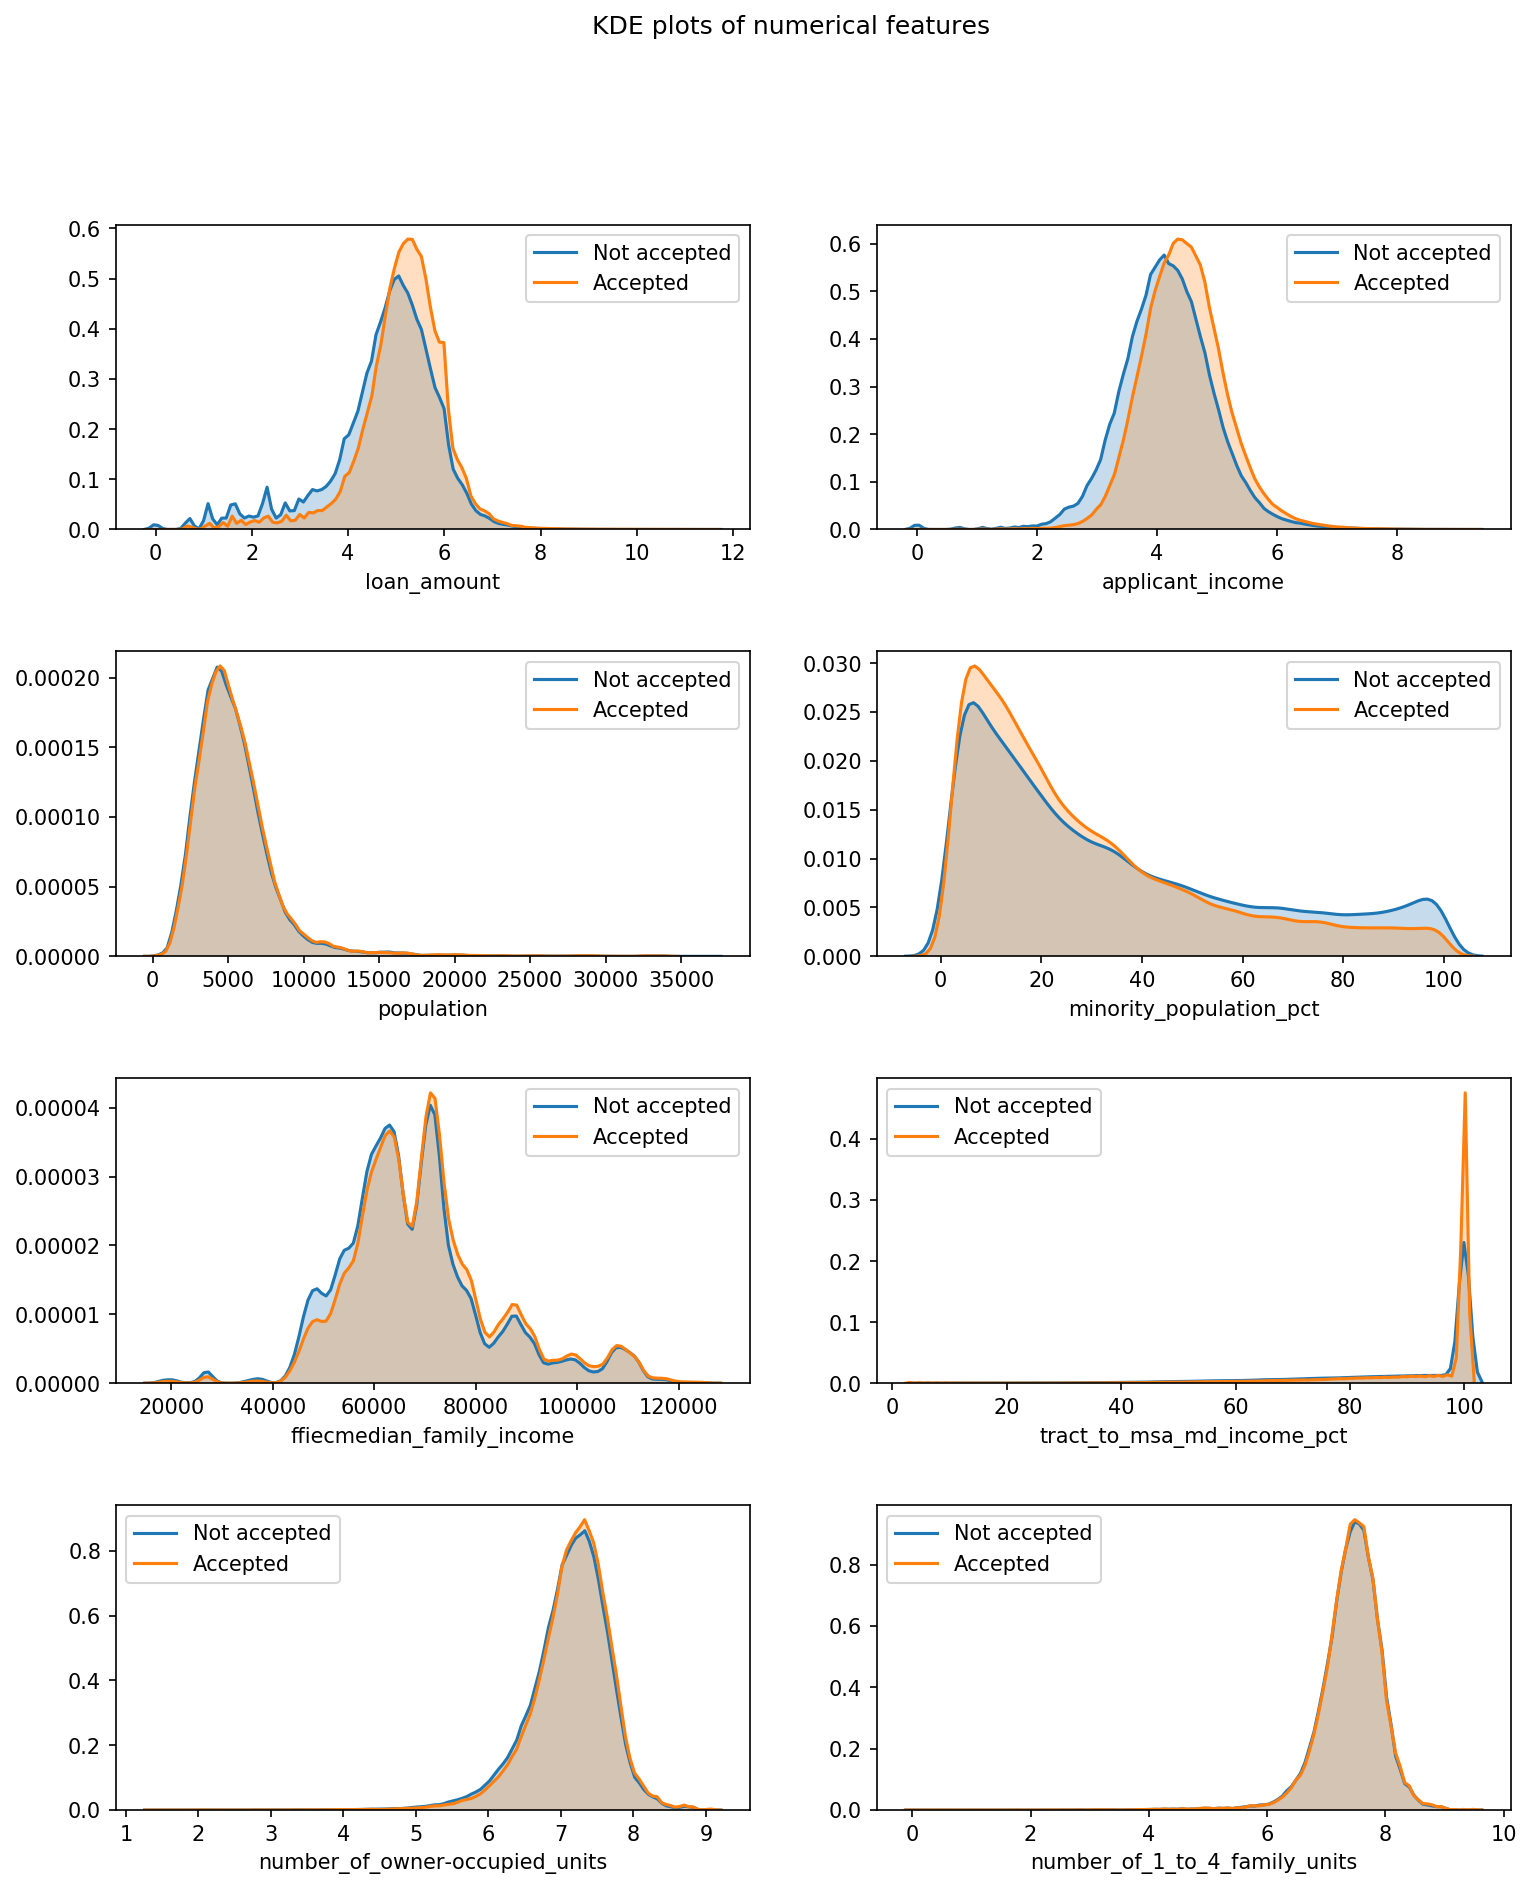

In [7]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (12,14))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
fig.suptitle("KDE plots of numerical features")

for ax, col in zip(axes.flatten(), numerical_cols) :
    sns.kdeplot(train[train["accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(train[train["accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)


Next, we're going to examine the KDE plots of the numerical features. I created different plots for each class of the label, so we can visually determine which features provide more information about the separation of those classes. As we can see *loan_amount*, *applicant_income*, *minority_population_pct* and *ffiecmedian_family_income* are the most important numerical features, and will be used for the creation of the binary classifier.

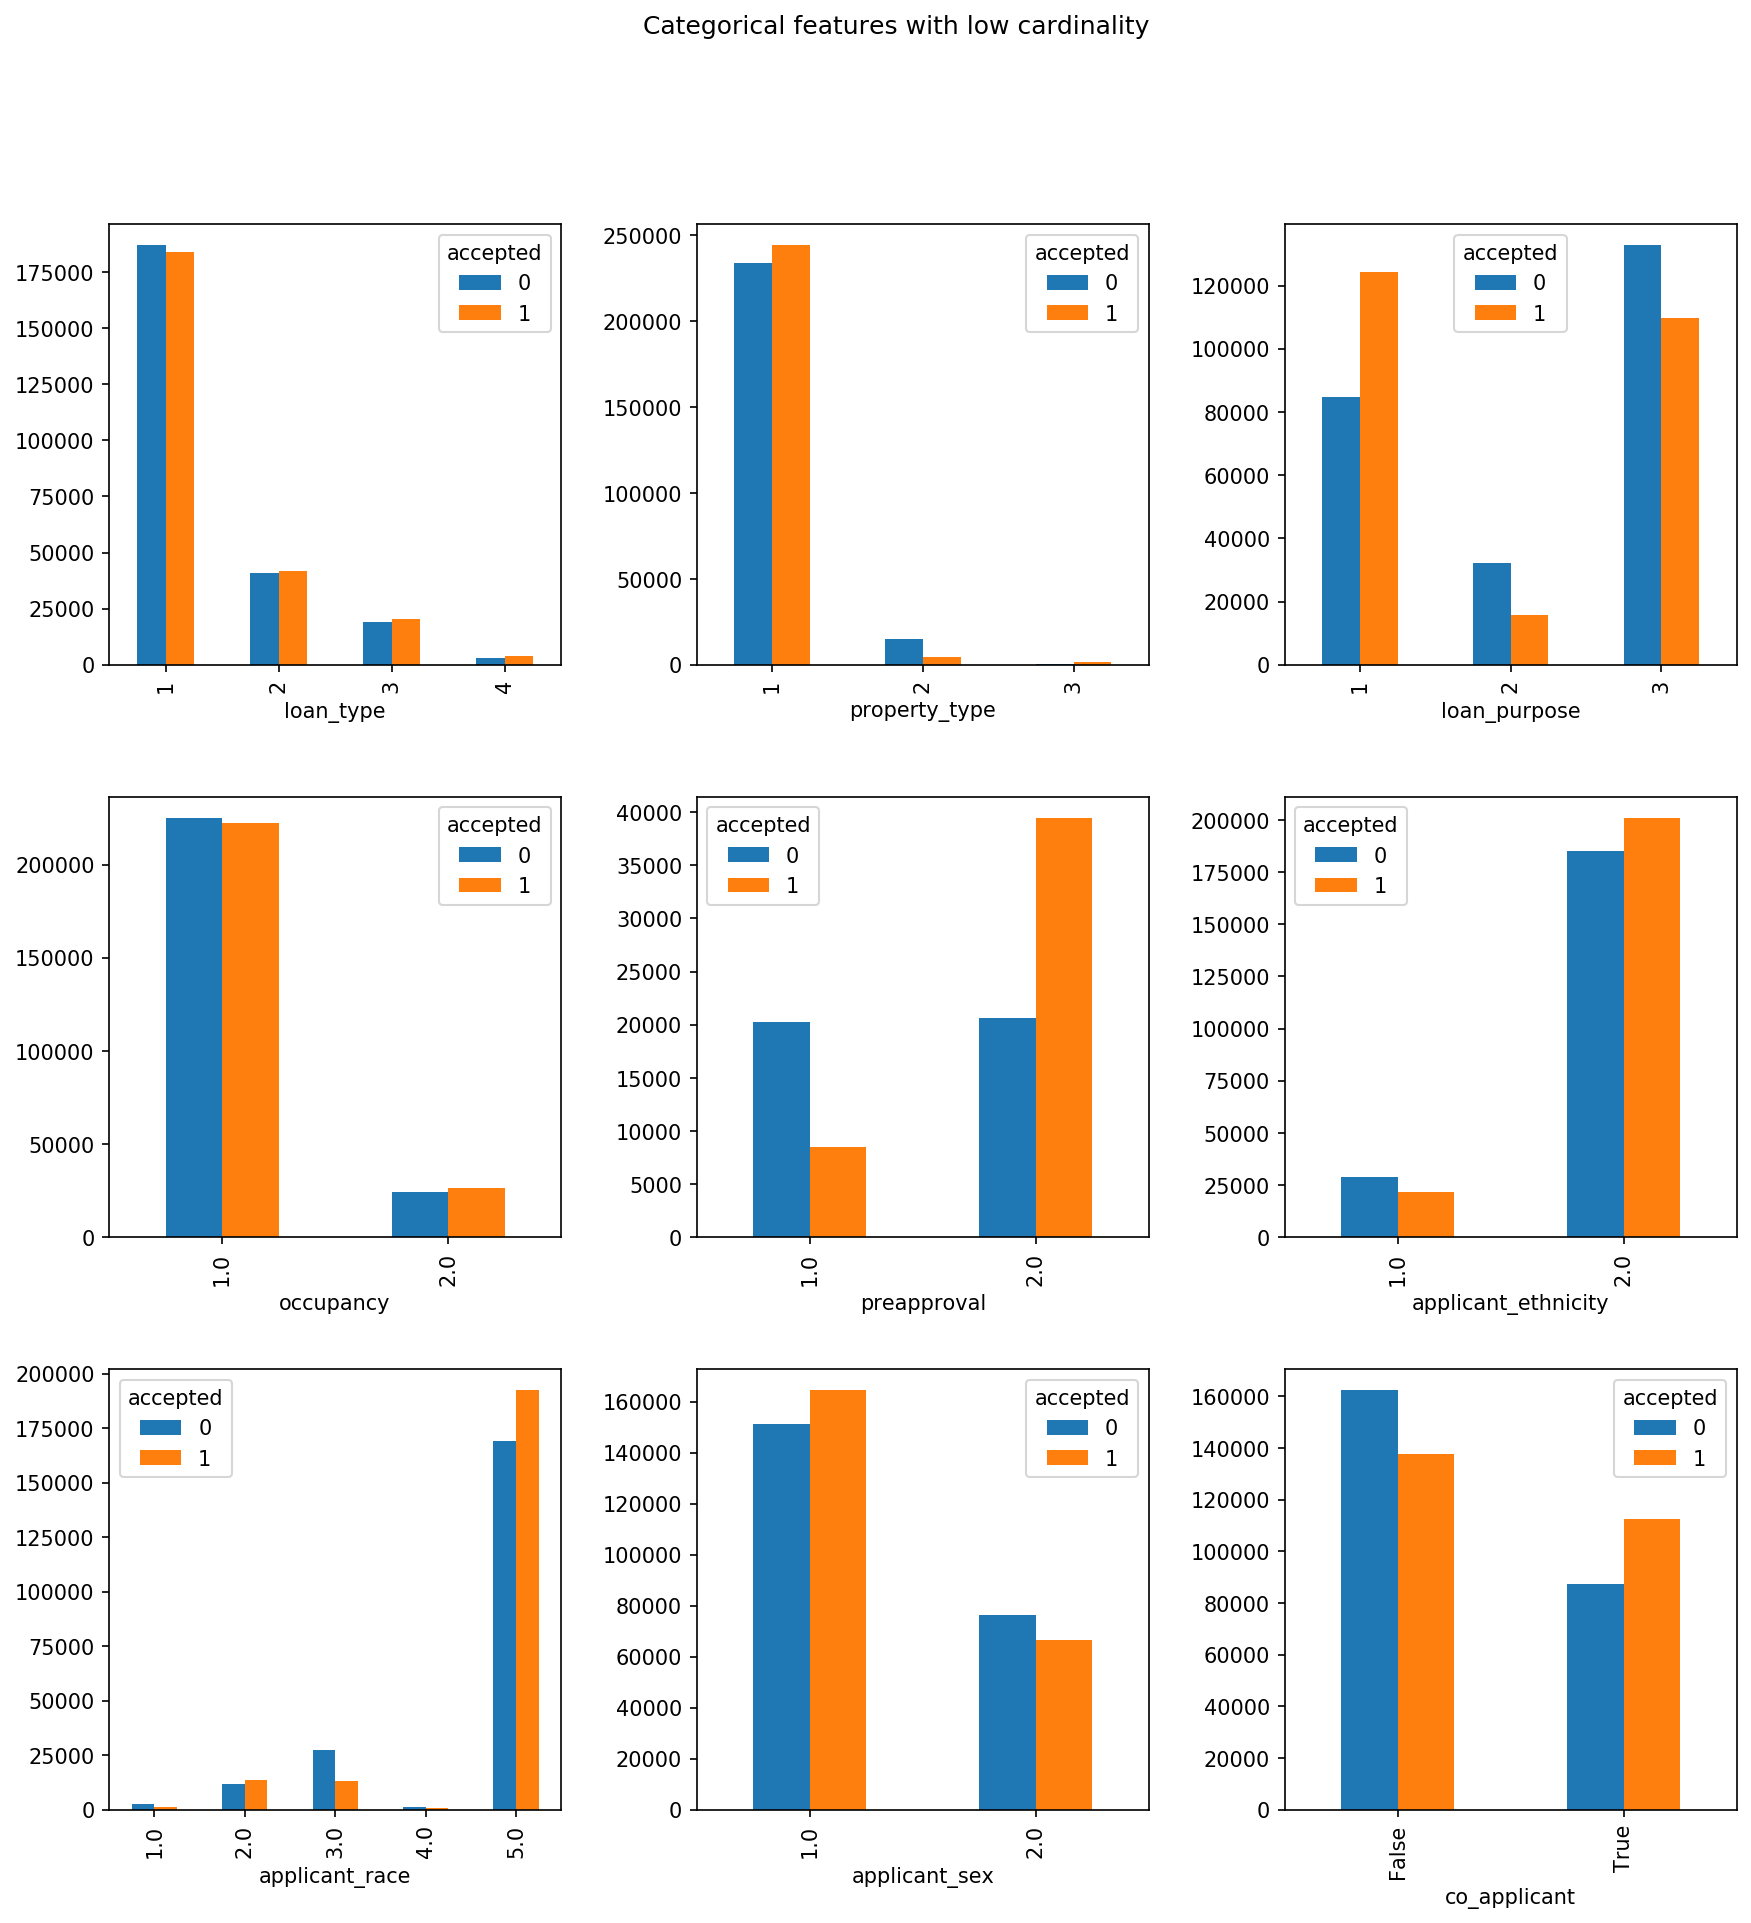

In [8]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (14,14))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features with low cardinality")

for ax, col in zip(axes.flatten(), cat_cols_few) :
    pd.crosstab(train[col], train["accepted"]).plot(kind="bar", ax = ax)
    ax.set_xlabel(col)

We are now going to visually examine class separation on the categorical features. I divided those features in two groups, depending on the number of categories, i.e. low and high cardinality. Ι decided to do this for a number of reasons, including the fact that features with low cardinality can be visualized using bar plots, while this isn't appropriate for those with high cardinality. As we can see, most of the low-cardinality features provide information about class separation, except for *occupancy*. It must be noted that there are some evident signs of discrimination, specifically based on sex and race. The mortgage applications of white citizens had a higher approval rate compared to african americans. Furthermore, women had a lower approval rate compared to men. Making inferences and trying to identify any causes for those differences, is beyond the scope of this analysis. Regardless of that, using data that is influenced by prejudice and discrimination, raises ethical concerns that will be examined later in further detail.

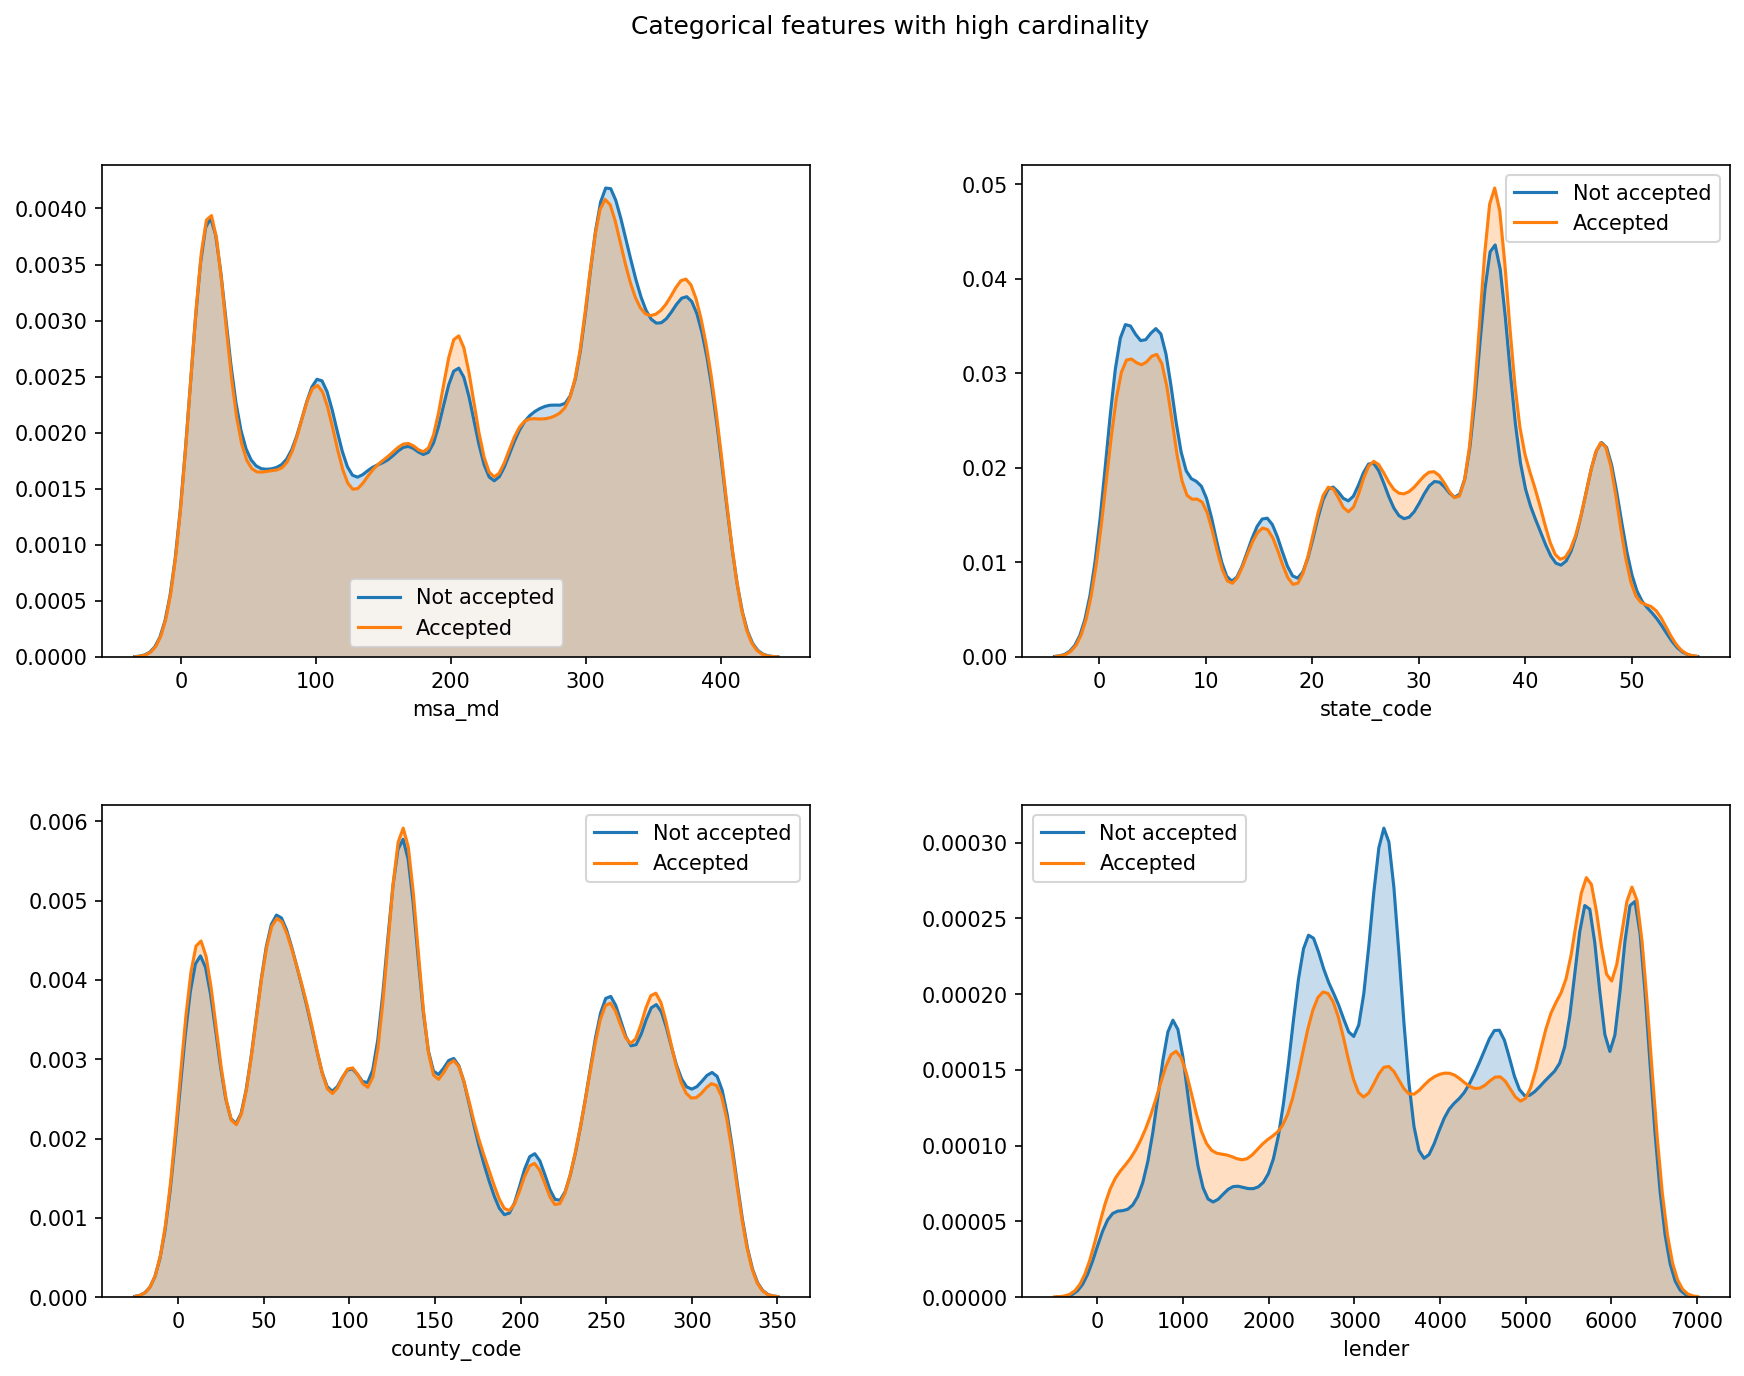

In [9]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (14,10))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features with high cardinality")

for ax, col in zip(axes.flatten(), cat_cols_many) :
    sns.kdeplot(train[train["accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(train[train["accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)


For the high-cardinality categorical features, I decided to use KDE plots. We can see that *lender* and *state_code* provide adequate information about the separation of the target classes.

In [10]:
train["minority_population"] = (train["minority_population_pct"] / 100) * (train["population"])
train["tract_family_income"] = (train["tract_to_msa_md_income_pct"] /100) * (train["ffiecmedian_family_income"])

train["minority_population"] = train["minority_population"].apply(math.log)

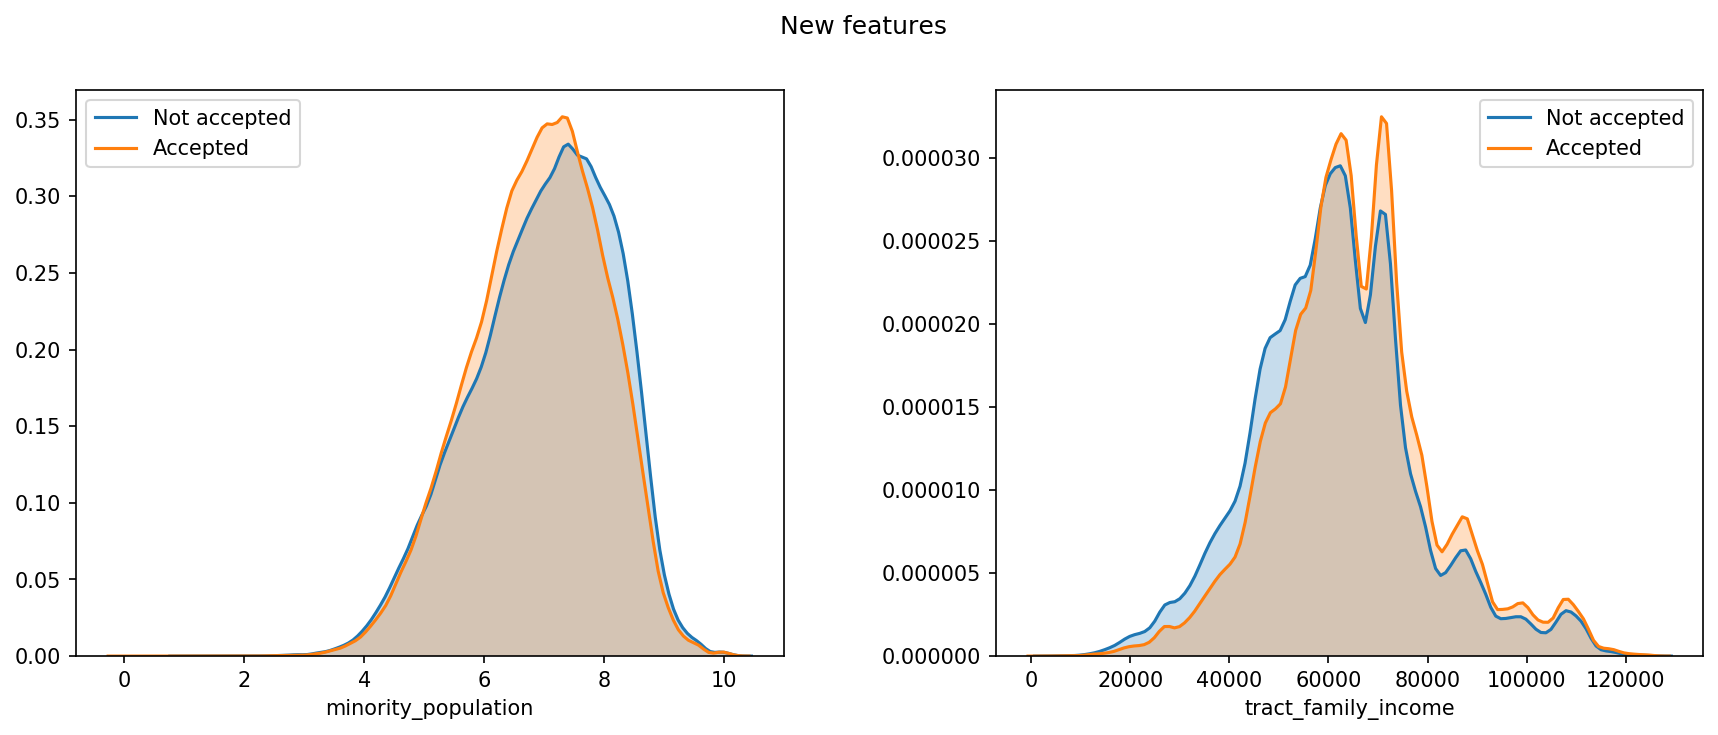

In [11]:
new_cols = ["minority_population", "tract_family_income"]

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (14,5))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
fig.suptitle("New features")

for ax, col in zip(axes.flatten(), new_cols) :
    sns.kdeplot(train[train["accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(train[train["accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)

I decided to create two new features, i.e. *minority_population* and *tract_family_income*. The first feature is the product of *minority_population_pct* and *population*, and contains the actual number of people that belong in a minority group. The second is the product of *tract_to_msa_md_income_pct* and *ffiecmedian_family_income*, and contains the tract median family income in dollars. It is evident from the KDE plots of those new features, that they both provide useful information about class separation, so they will be used in the binary classifier.

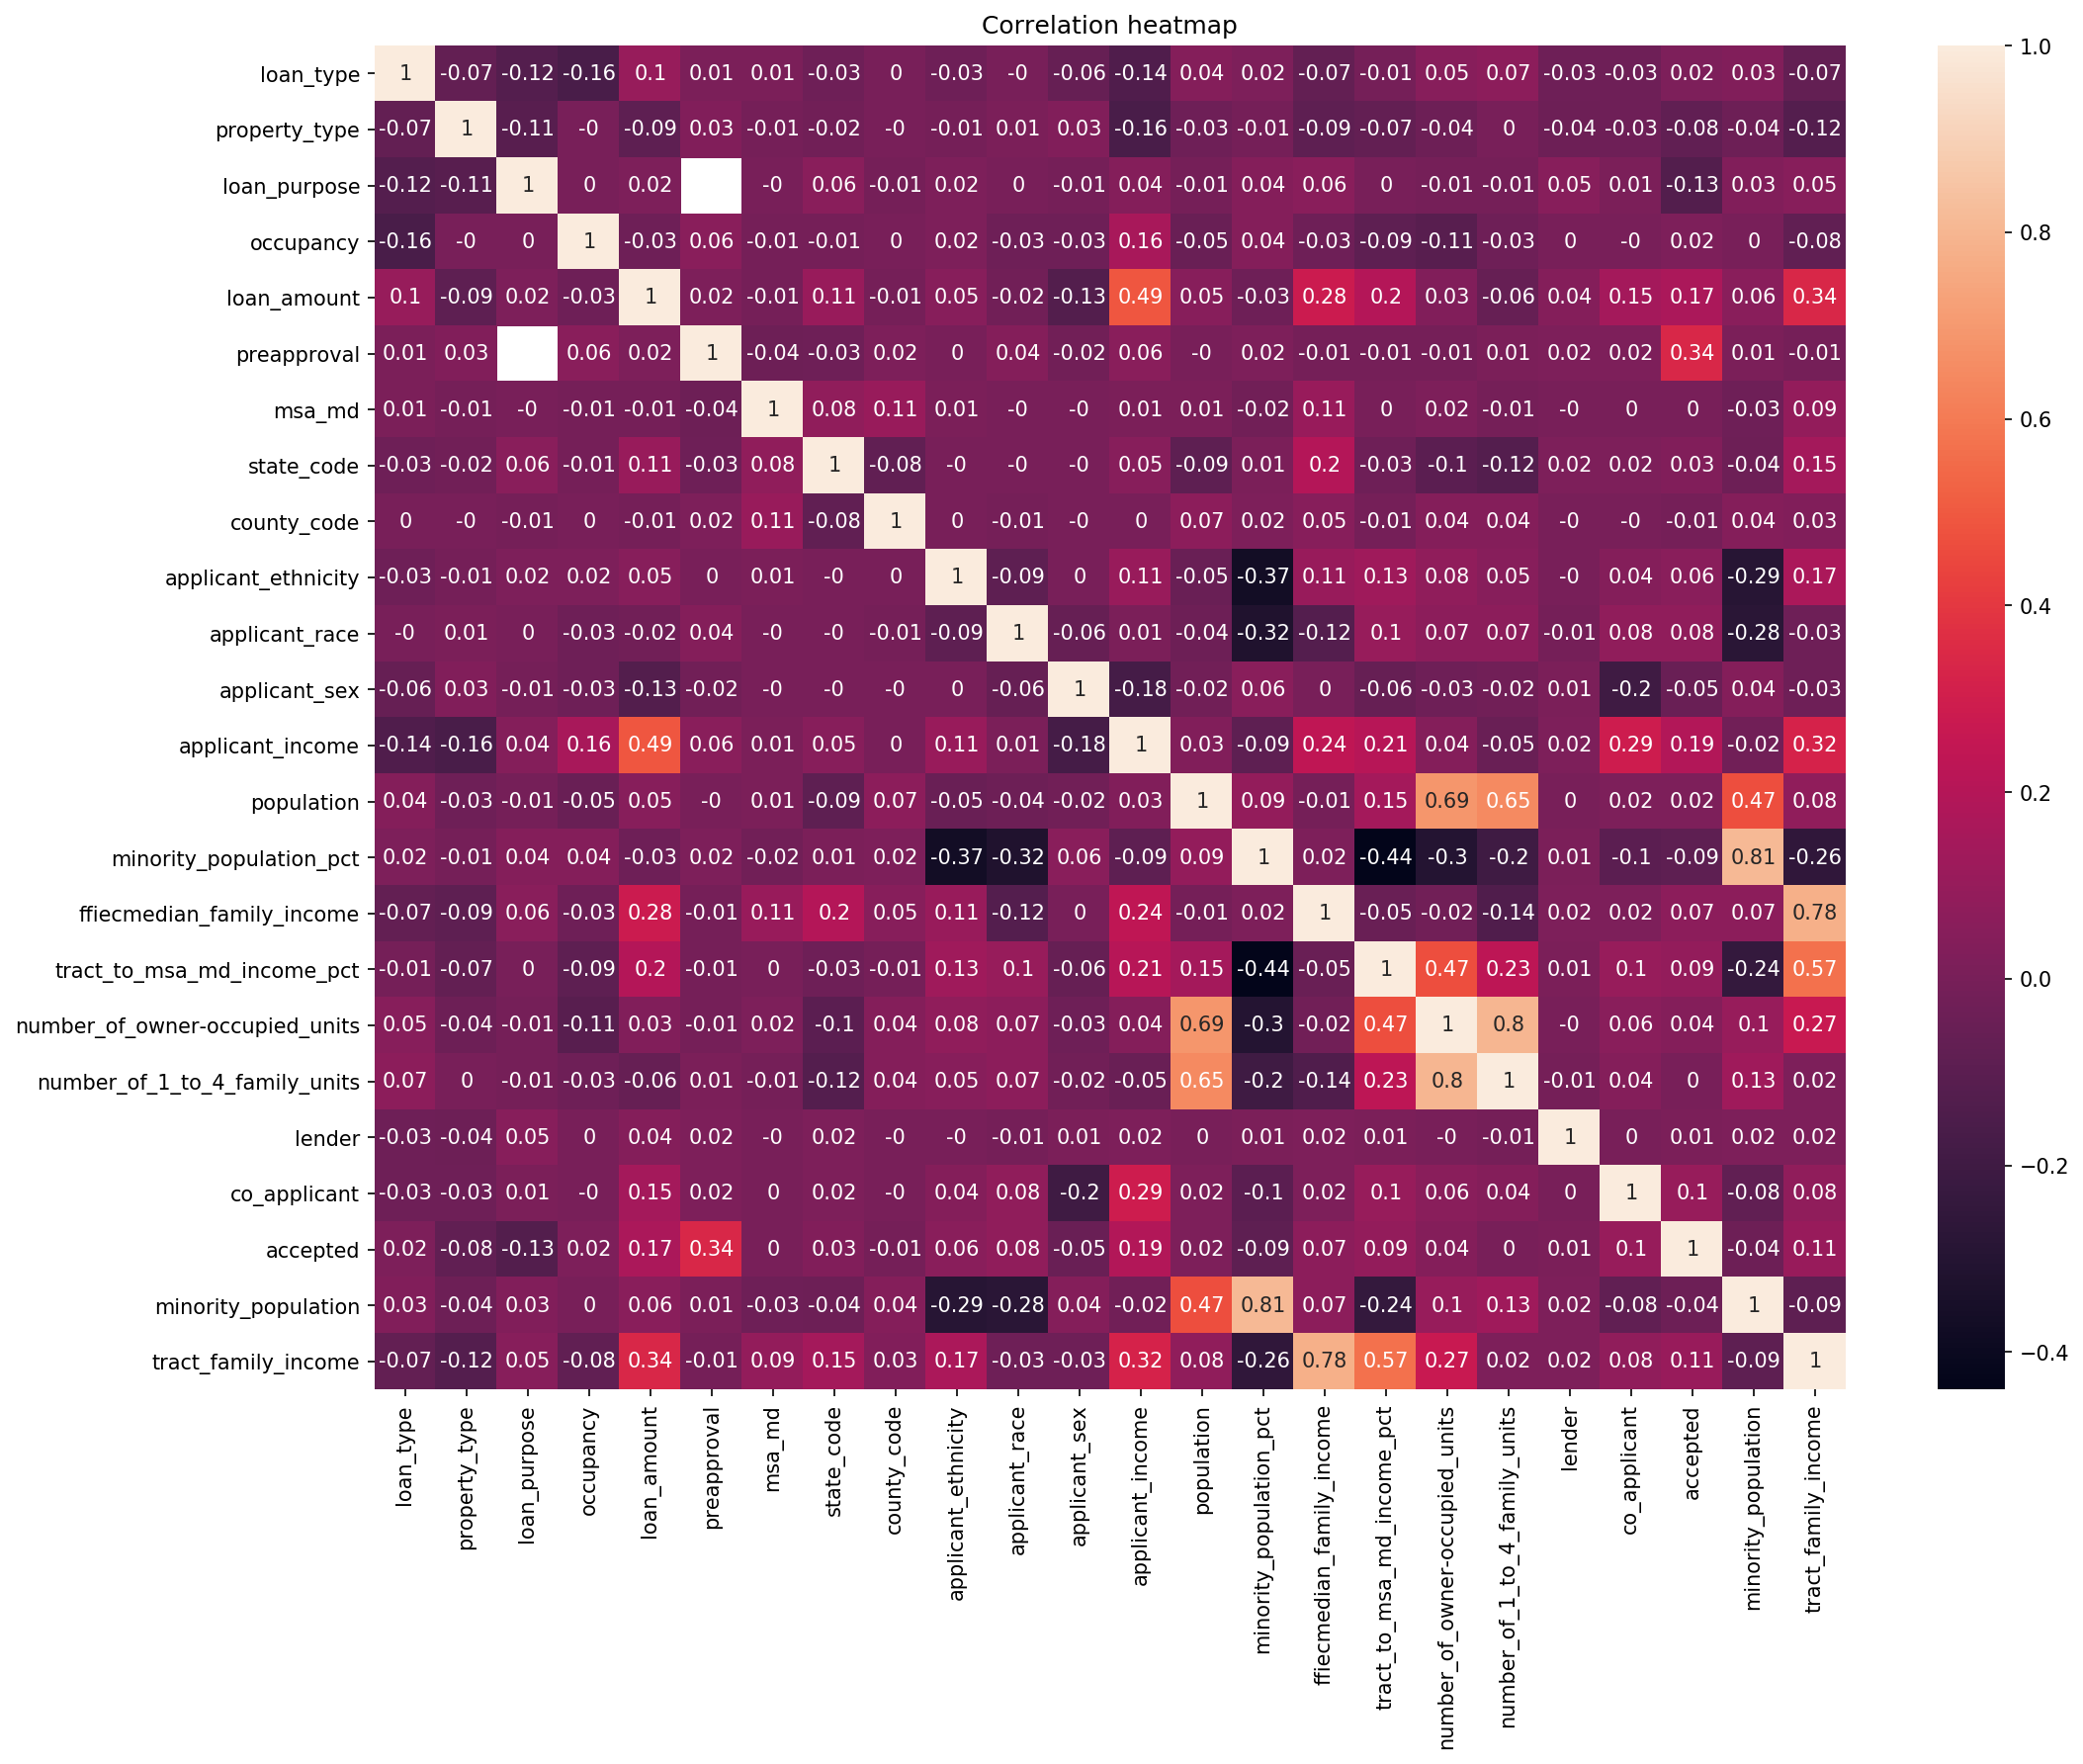

In [12]:
plt.figure(figsize=(16,12))
sns.heatmap(train.corr().round(decimals=2), annot=True)
plt.title("Correlation heatmap")
plt.show()

The correlation heatmap helps us visually identify any features that are highly correlated. Including those in the binary classifier is redundant, because the information they provide is highly overlapping, so they will be discarded from the final dataset. We can see that the new features we created earlier, are highly correlated with those that comprise them. This is fairly self-evident and reasonable, so I decided to drop the original features.

# Machine Learning Modelling
For the creation of the binary classifier, I experimented with various algorithms and techniques. First of all I tested the accuracy of some typical classification algorithms, such as Logistic Regression, K-Nearest Neighbors and Support Vector Machines. The accuracy I got with them was below 70%, and that was unacceptable. I also tried more sophisticated algorithms and machine learning libraries, like LightGBM and Keras/Tensorflow. Eventually, I got the highest accuracy (about 72.5%) with the XGBoost library. I used the XGBoost Classifier for the main modelling, as well as various functions of the scikit-earn library for data preprocessing, metrics, and model selection.
First of all, I created a *prepare_data* function that dealt with missing values by imputing them with the median/mode value of each feature, depending on whether it was a numerical or categorical one. It also applied the logarithmic function to the skewed numerical features, as mentioned earlier. Afterwards, I applied one-hot encoding to the categorical features, as it is typical in machine learning. I ran into a problem though, as the encoded high-cardinality features resulted in the dramatic increase of the dataset size.
This was normal, as thousands of features were added to it, but led to memory problems and increased the time needed to train the machine learning models. After doing some research, I decided to apply target encoding to the high-cardinality features, i.e. *lender*, *msa_md* and *state_code*, instead of one-hot encoding, thus solving the problem. After that, I used the StandardScaler class of scikit-learn to scale my dataset, as well as the RandomizedSearchCV class to do a combination of cross-validation and parameter tuning. RandomizedSearchCV tests a sample of hyperparameter combinations for a given estimator, and helps us choose the best one. 

    Best estimator:
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=8, min_child_weight=8, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

     Best score for 3-fold search with 10 parameter combinations:
     0.728162

This is the best hyperparameter combination according to RandomizedSearchCV. I am going to use train_test_split to examine our classifier in more detail.

In [13]:
to_log = ["loan_amount", "applicant_income", "number_of_owner-occupied_units",
          "number_of_1_to_4_family_units", "minority_population"]

to_drop = ["row_id", "number_of_1_to_4_family_units",
           "occupancy", "preapproval", "county_code"]

num_cols = ["loan_amount", "applicant_income", "population", "minority_population_pct",
            "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
            "number_of_owner-occupied_units"]

cat_cols_few = ["loan_type", "property_type", "loan_purpose",
            "applicant_ethnicity", "applicant_race",
            "applicant_sex", "co_applicant"]

def prepare_data(df):
    
    df["co_applicant"] = df["co_applicant"].astype("int8")
    
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
        
    for col in cat_cols_few:
        df[col].fillna(df[col].mode()[0], inplace=True)
        
    df["minority_population"] = (df["minority_population_pct"] / 100) * (df["population"])
    df["tract_family_income"] = (df["tract_to_msa_md_income_pct"] / 100) * (df["ffiecmedian_family_income"])

    df[to_log] = df[to_log].applymap(math.log)
    
    to_drop.extend(["minority_population_pct", "population",
                    "ffiecmedian_family_income", "tract_to_msa_md_income_pct"])
    df.drop(to_drop, axis=1, inplace=True)
    
    df = pd.get_dummies(df, columns = cat_cols_few)
    
    return df

In [14]:
X_train = prepare_data(X_train)

ce_target = ce.TargetEncoder(cols = ["lender", "msa_md", "state_code"], smoothing = 5, return_df = True)
X_train = ce_target.fit_transform(X_train, y_train["accepted"])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train.values, y_train["accepted"].values, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=8, min_child_weight=8, missing=None, n_estimators=600,
       n_jobs=-1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

model.fit(X_train, y_train)
prediction = model.predict(X_test)

The accuracy is: 0.7275066666666666


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71     74876
           1       0.71      0.78      0.74     75124

    accuracy                           0.73    150000
   macro avg       0.73      0.73      0.73    150000
weighted avg       0.73      0.73      0.73    150000



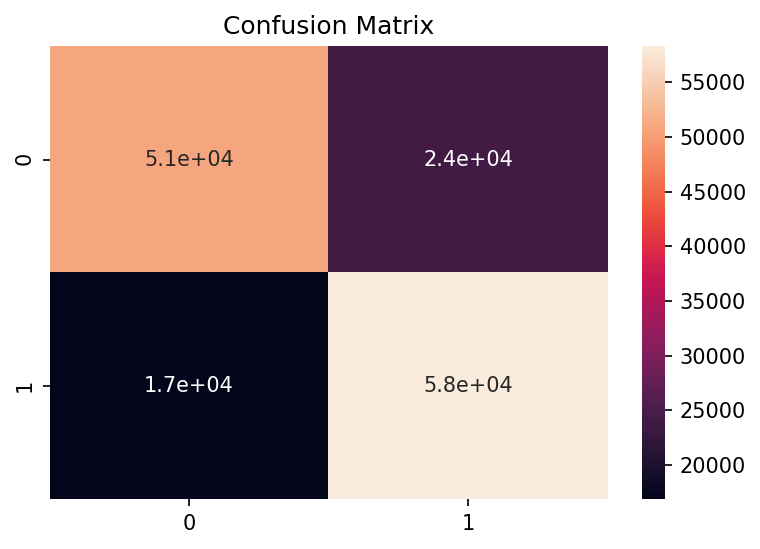

In [20]:
print('The accuracy is:', metrics.accuracy_score(y_test, prediction))
print("\n")
print("Classification Report:")
print(metrics.classification_report(y_test, prediction))

sns.heatmap(confusion_matrix(y_test, prediction), annot=True)
plt.title("Confusion Matrix")
plt.show()

As we can see from the classification report, as well as the confusion matrix, the classifier is fairly accurate, but outputs a number of false positive and false  negative values as well.

# Ethical Concerns And Conclusion
The accuracy of our binary classifier is satisfactory. It could possibly be improved if more useful features were added on the dataset, or by exploring the performance of other algorithms and techniques. As it was mentioned before though, our data analysis indicates that there is discrimination against specific groups of people in the approval of mortgages, i.e. based on race, nationality and sex. Including that information in a real-world data science project, would possibly reinforce and exacerbate that problem. I would personally be reluctant to do it, as it is ethically questionable. Of course in a business environment, that decision might not be mine to make, so I would discuss that issue with a manager, or the head of my department. Regardless, our goal in this project was simply to maximize the accuracy of the classifier in the context of an online course, so all of the relevant features were included in the machine learning model.